<a href="https://colab.research.google.com/github/krisbarbier/Project-2/blob/main/Kris_B_Project2_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project 2, Part 2

##Imports


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Display all columns
pd.set_option('display.max_column', None)

##Custom Functions

In [47]:
# Updating function
def plot_categorical_vs_target(df, x, y, figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None, target_type='reg'):
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)
  # REGRESSION-TARGET PLOT
  if target_type=='reg': #Added if statement here
    # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
                linewidth=1, edgecolor='black', errorbar=None)
    # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                  order=order, hue_order=order, legend=False,
                  edgecolor='white', linewidth=0.5,
                  size=3,zorder=0)
  # CLASSIFICATION-TARGET PLOT # This is the new code for the classification task
  elif target_type=='class':
    ax = sns.histplot(data=temp_df, hue=y, x=x, stat='percent',  multiple='fill')
  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # Added this to prevent a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax


# Updating the function
def plot_numeric_vs_target(df, x, y, figsize=(6,4),
                           target_type='reg', estimator='mean',
                           errorbar='ci',sorted=False,ascending=False,
                           **kwargs): # kwargs for sns.regplot

  nulls = df[[x,y]].isna().sum()
  if nulls.sum()>0:
    print(f"- Excluding {nulls.sum()} NaN's")
    # print(nulls)
    temp_df = df.dropna(subset=[x,y,])
  else:
    temp_df = df
  # Create the figure
  fig, ax = plt.subplots(figsize=figsize)

  # REGRESSION-TARGET PLOT
  if 'reg' in target_type:
    # Calculate the correlation
    corr = df[[x,y]].corr().round(2)
    r = corr.loc[x,y]
    # Plot the data
    scatter_kws={'ec':'white','lw':1,'alpha':0.8}
    sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
    ## Add the title with the correlation
    ax.set_title(f"{x} vs. {y} (r = {r})")

  # CLASSIFICATION-TARGET PLOT
  elif 'class' in target_type:

    # Sort the groups by median/mean
    if sorted == True:

      if estimator == 'median':
        group_vals = temp_df.groupby(y)[x].median()
      elif estimator =='mean':
        group_vals = temp_df.groupby(y)[x].mean()

      ## Sort values
      group_vals = group_vals.sort_values(ascending=ascending)
      order = group_vals.index

    else:
      # Set order to None if not calcualted
      order = None


    # Left Subplot (barplot)
    sns.barplot(data=temp_df, x=y, y=x, order=order,  estimator=estimator,
                errorbar=errorbar, ax=ax, **kwargs)

    # Add title
    ax.set_title(f"{x} vs. {y}")

    # rotate xaxis labels
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


  # Final Adjustments & return
  fig.tight_layout()
  fig.show()
  return fig, ax

In [2]:
#UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:{PASTE IN FINAL LESSON LINK}
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes


##Load and Inspect Data

In [4]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Copy file path
fpath = '/content/drive/MyDrive/CodingDojo/02-MachineLearning/Metabolic  Syndrome.csv'

#Read in data with pandas
df = pd.read_csv(fpath)

#Preview first 5 rows of data
df.head()

,seqn,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,62161,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,62164,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,62169,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,62172,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,62177,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


- The data loaded correctly.

In [6]:
#Preview info with null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   seqn               2401 non-null   int64  
 1   Age                2401 non-null   int64  
 2   Sex                2401 non-null   object 
 3   Marital            2193 non-null   object 
 4   Income             2284 non-null   float64
 5   Race               2401 non-null   object 
 6   WaistCirc          2316 non-null   float64
 7   BMI                2375 non-null   float64
 8   Albuminuria        2401 non-null   int64  
 9   UrAlbCr            2401 non-null   float64
 10  UricAcid           2401 non-null   float64
 11  BloodGlucose       2401 non-null   int64  
 12  HDL                2401 non-null   int64  
 13  Triglycerides      2401 non-null   int64  
 14  MetabolicSyndrome  2401 non-null   object 
dtypes: float64(5), int64(6), object(4)
memory usage: 281.5+ KB


- There are 5 float, 6 integer, and 4 object type columns.
- The first column, seqn may not be needed for modeling.
- There are 4 columns with missing values.

In [7]:
#Check shape of df
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns.')

There are 2401 rows and 15 columns.


##Clean Data

###Duplicates

In [10]:
#Check for duplicate rows
print(f'There are {df.duplicated().sum()} duplicate rows.')

There are 0 duplicate rows.


- There are no duplicate rows to be dropped.

###Unnecessary Columns

In [11]:
#Check unique counts for seqn column
df['seqn'].nunique()

2401

- Because this has such high cardinality, and it seems to be a unique identifier for the data, I will drop this column from the set.

In [12]:
#Drop seqn from dataframe
df = df.drop(columns= 'seqn')

#Verify the change
df.head()

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
0,22,Male,Single,8200.0,White,81.0,23.3,0,3.88,4.9,92,41,84,No MetSyn
1,44,Female,Married,4500.0,White,80.1,23.2,0,8.55,4.5,82,28,56,No MetSyn
2,21,Male,Single,800.0,Asian,69.6,20.1,0,5.07,5.4,107,43,78,No MetSyn
3,43,Female,Single,2000.0,Black,120.4,33.3,0,5.22,5.0,104,73,141,No MetSyn
4,51,Male,Married,NaN,Asian,81.1,20.1,0,8.13,5.0,95,43,126,No MetSyn


- The column was dropped successfully.

###Incorrect Data Types

In [13]:
#Check column data types
df.dtypes

Age                    int64
Sex                   object
Marital               object
Income               float64
Race                  object
WaistCirc            float64
BMI                  float64
Albuminuria            int64
UrAlbCr              float64
UricAcid             float64
BloodGlucose           int64
HDL                    int64
Triglycerides          int64
MetabolicSyndrome     object
dtype: object

- All column data types are as expected, and do not need to be changed.
- I will, however, binarize the MetabolicSyndrome column to help with EDA.

In [34]:
#Binarize MetabolicSyndrome
df['MetabolicSyndrome'] = df['MetabolicSyndrome'].replace({'No MetSyn': 0, 'MetSyn': 1})

#Verify the change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2401 entries, 0 to 2400
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2401 non-null   int64  
 1   Sex                2401 non-null   object 
 2   Marital            2193 non-null   object 
 3   Income             2284 non-null   float64
 4   Race               2401 non-null   object 
 5   WaistCirc          2316 non-null   float64
 6   BMI                2375 non-null   float64
 7   Albuminuria        2401 non-null   int64  
 8   UrAlbCr            2401 non-null   float64
 9   UricAcid           2401 non-null   float64
 10  BloodGlucose       2401 non-null   int64  
 11  HDL                2401 non-null   int64  
 12  Triglycerides      2401 non-null   int64  
 13  MetabolicSyndrome  2401 non-null   int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 262.7+ KB


###Inconsistencies

In [35]:
#Save a list of object columns
cat_cols = df.select_dtypes('object')

#Loop through cat_cols and display values
for col in cat_cols:
  print(f'Column: {col}')
  print(df[col].value_counts())
  print('\n')

Column: Sex
Female    1211
Male      1190
Name: Sex, dtype: int64


Column: Marital
Married      1192
Single        498
Divorced      242
Widowed       166
Separated      95
Name: Marital, dtype: int64


Column: Race
White          933
Black          548
Asian          349
Hispanic       257
MexAmerican    253
Other           61
Name: Race, dtype: int64




- There are no inconsistencies in these columns to fix.

###Impossible Values

In [36]:
#Check summary statistics for impossible values and outliers
df.describe()

,Age,Income,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
count,2401.000000,2284.000000,2316.000000,2375.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000,2401.000000
mean,48.691795,4005.253940,98.307254,28.702189,0.154102,43.626131,5.489046,108.247813,53.369429,128.125364,0.342357
std,17.632852,2954.032186,16.252634,6.662242,0.422780,258.272829,1.439358,34.820657,15.185537,95.322477,0.474597
min,20.000000,300.000000,56.200000,13.400000,0.000000,1.400000,1.800000,39.000000,14.000000,26.000000,0.000000
25%,34.000000,1600.000000,86.675000,24.000000,0.000000,4.450000,4.500000,92.000000,43.000000,75.000000,0.000000
50%,48.000000,2500.000000,97.000000,27.700000,0.000000,7.070000,5.400000,99.000000,51.000000,103.000000,0.000000
75%,63.000000,6200.000000,107.625000,32.100000,0.000000,13.690000,6.400000,110.000000,62.000000,150.000000,1.000000
max,80.000000,9000.000000,176.000000,68.700000,2.000000,5928.000000,11.300000,382.000000,156.000000,1562.000000,1.000000


- There looks like there could be an outlier in UrAlbCr, as well as HDL.

In [37]:
#Filter out high UrAlbCr levels
df[df['UrAlbCr'] >= 1000]

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
50,80,Male,Married,2500.0,White,88.6,21.7,2,3267.57,4.7,135,44,75,0
140,80,Female,Married,2500.0,White,97.5,30.8,2,3284.62,7.8,132,65,130,1
212,74,Female,Divorced,800.0,Asian,111.7,35.3,2,1777.05,7.2,104,37,111,1
246,50,Male,Separated,2000.0,Black,75.5,19.6,2,2750.00,5.7,127,80,92,0
312,39,Female,Single,9000.0,Black,118.0,37.5,2,2238.10,7.1,291,34,248,1
324,48,Male,Married,1500.0,MexAmerican,123.0,38.5,2,2403.85,6.6,100,53,166,1
418,69,Male,Married,2500.0,Asian,93.2,27.2,2,1817.31,6.7,99,64,93,0
872,63,Female,Separated,1600.0,MexAmerican,111.5,35.2,2,1276.60,8.1,47,60,159,1
891,80,Female,Separated,2500.0,Black,103.1,30.4,2,1511.11,6.2,250,47,80,1
910,58,Male,Married,2000.0,MexAmerican,100.6,25.6,2,3666.67,8.8,211,48,188,0


- Upon further research, the higher the UrAlbCr level, the more likely this person is to have kidney disease, and could be a result of a complication from diabetes. While these levels seem very high, I will leave them as is for now.

In [38]:
#Filter out high HDL levels
df[df['HDL'] >= 100]

,Age,Sex,Marital,Income,Race,WaistCirc,BMI,Albuminuria,UrAlbCr,UricAcid,BloodGlucose,HDL,Triglycerides,MetabolicSyndrome
195,55,Female,Separated,1600.0,Black,76.1,20.3,0,22.91,5.5,83,119,46,0
220,61,Male,Separated,1000.0,Black,87.2,18.7,1,37.26,7.1,105,150,74,0
304,68,Female,Married,2500.0,Black,80.4,21.5,0,4.38,5.1,90,100,61,0
403,72,Male,NaN,1600.0,MexAmerican,101.0,25.7,0,3.49,5.6,99,106,89,0
798,55,Male,Single,1600.0,White,103.8,24.4,0,5.22,5.7,88,108,77,0
862,37,Female,Single,8200.0,Black,85.2,25.9,0,3.66,4.6,92,104,37,0
959,57,Female,Divorced,6200.0,Black,77.9,21.5,0,6.52,3.4,93,138,54,0
1310,75,Female,Widowed,1000.0,Black,NaN,26.7,1,151.70,7.4,108,156,64,0
1453,79,Female,Married,9000.0,White,79.7,22.5,0,20.00,4.5,105,107,95,0
1512,73,Female,Divorced,3500.0,Black,107.2,27.8,1,39.32,6.4,97,104,97,0


- Upon further research, the HDL level is a possible level, although it is quite a bit higher than the 75% percentile in this dataset.

###Missing Values

In [39]:
#Check missing values in each column
df.isna().sum()

Age                    0
Sex                    0
Marital              208
Income               117
Race                   0
WaistCirc             85
BMI                   26
Albuminuria            0
UrAlbCr                0
UricAcid               0
BloodGlucose           0
HDL                    0
Triglycerides          0
MetabolicSyndrome      0
dtype: int64

- The only columns with missing values are Marital, Income, WaistCirc, and BMI. Depending on the overall distributions of each of these, I will determine how to impute them when it is time to produce machine learning models.

##Feature Inspection

###Age

- Age: The patient's age.

In [40]:
#Univariate EDA
#Comfirm data type for function call
age_feature = 'Age'
df[age_feature].dtype

dtype('int64')

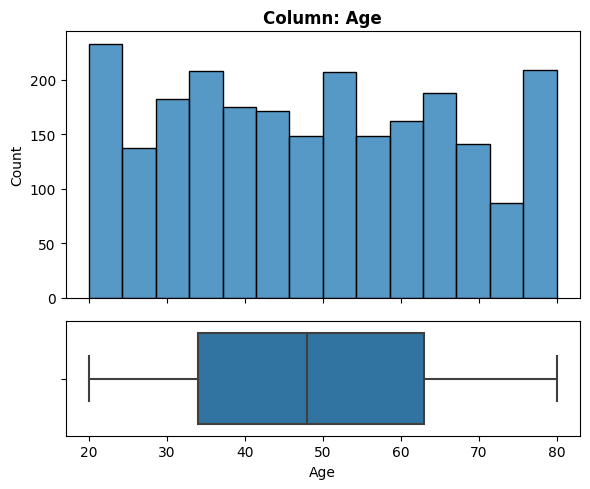

- NaN's Found: 0 (0.0%)
- Unique Values: 61
- Most common value: '80' occurs 124 times (5.16%)
- Not constant or quasi-constant.


In [41]:
#Call numeric function
explore_numeric(df, age_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

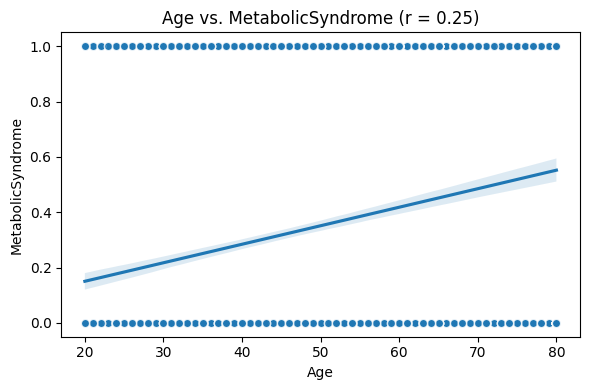

In [50]:
#Multivariate EDA
target = 'MetabolicSyndrome'
plot_numeric_vs_target(df, age_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect that age could be a predictor of metabolic syndrome as some of these health metrics get worse with age.
2. Does this feature appear to be a predictor of the target?
  - There is a slight correlation between age and metabolic syndrome diagnosis.

###Sex

- Sex: The patient's gender.

In [43]:
#Univariate EDA
#Comfirm data type for function call
sex_feature = 'Sex'
df[sex_feature].dtype

dtype('O')

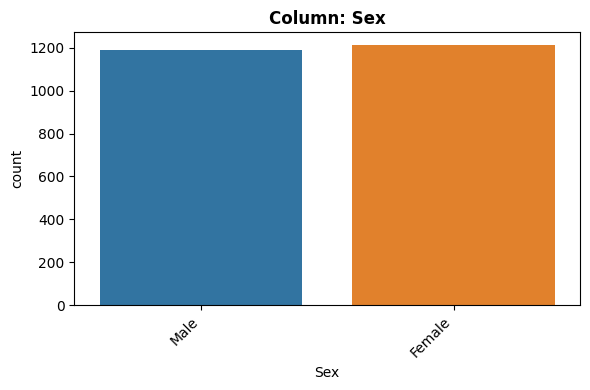

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Female' occurs 1211 times (50.44%)
- Not constant or quasi-constant.


In [44]:
#Call categorical function
explore_categorical(df, sex_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no missing values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is low, with 2 unique values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

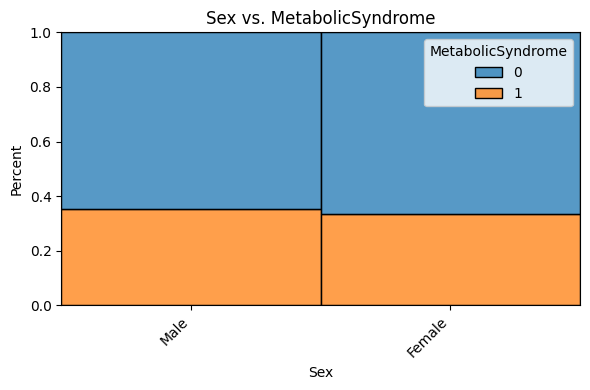

In [48]:
#Multivariate EDA
plot_categorical_vs_target(df, sex_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect sex to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is a slightly higher instance of metabolic syndrome in males, this is not a strong predictor of the condition.

###Marital

- Marital: The patient's marital status.

In [51]:
#Univariate EDA
#Comfirm data type for function call
marital_feature = 'Marital'
df[marital_feature].dtype

dtype('O')

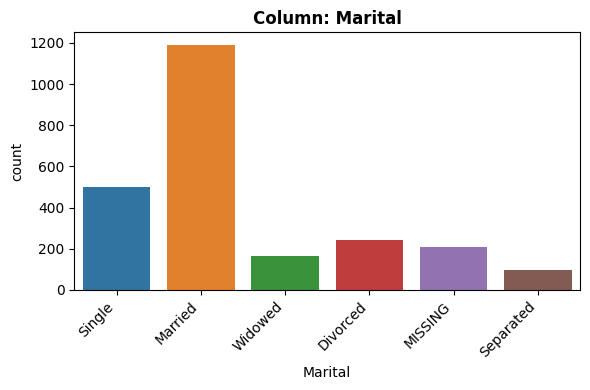

- NaN's Found: 208 (8.66%)
- Unique Values: 6
- Most common value: 'Married' occurs 1192 times (49.65%)
- Not constant or quasi-constant.


In [52]:
#Call categorical function
explore_categorical(df, marital_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 208 or 8.66% null values. I would impute them with either the most frequent, which is 'married,' or a placeholder. The placeholder will not increase the cardinality to a point where it will be unusable.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is medium, with 6 values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

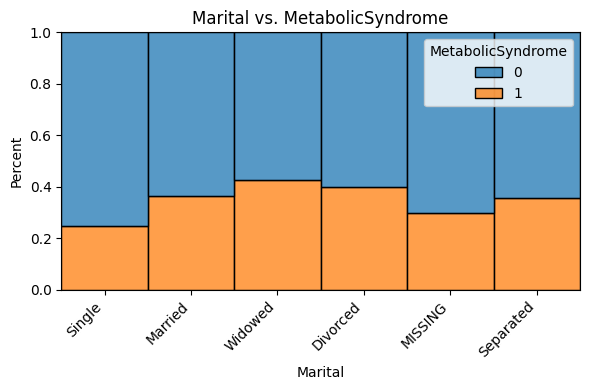

In [53]:
#Multivariate EDA
plot_categorical_vs_target(df, marital_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect marital status to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is some variation between the classes here, it does not really indicate that this is a predictor of metabolic syndrome.

###Income

- Income: The patient's monthly income.

In [54]:
#Univariate EDA
#Comfirm data type for function call
income_feature = 'Income'
df[income_feature].dtype

dtype('float64')

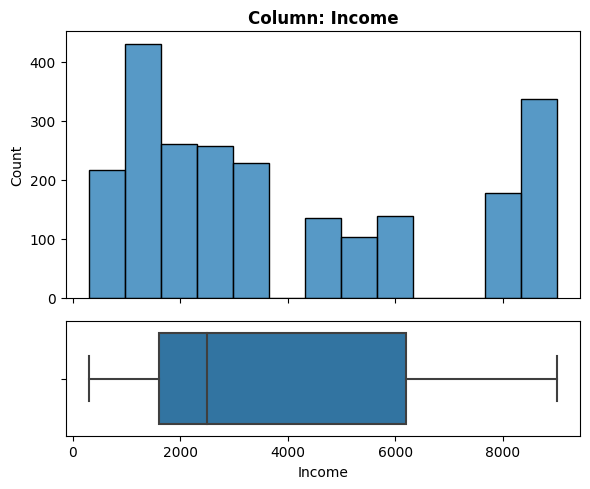

- NaN's Found: 117 (4.87%)
- Unique Values: 14
- Most common value: '9000.0' occurs 337 times (14.04%)
- Not constant or quasi-constant.


In [55]:
#Call numeric function
explore_numeric(df, income_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 117 or 4.87% null values. These will be imputed with either the mean or the median.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 117 NaN's


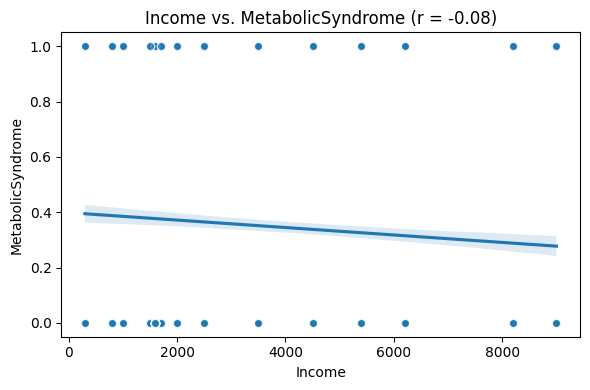

In [58]:
#Multivariate EDA
plot_numeric_vs_target(df, income_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - No, I would not expect that a person's income level will directly influence whether or not they develop metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - There is a very slight negative correlation between income and metabolic syndrome, showing that this is not a signifiant indicator of the disease.

###Race

- Race: The patient's ethnicity.

In [59]:
#Univariate EDA
#Comfirm data type for function call
race_feature = 'Race'
df[race_feature].dtype

dtype('O')

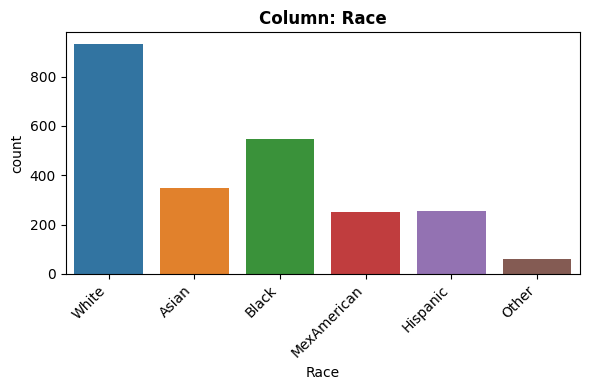

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'White' occurs 933 times (38.86%)
- Not constant or quasi-constant.


In [60]:
#Call categorical function
explore_categorical(df, race_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is categorical(nominal).
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are no null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - The cardinality is medium, with 6 values.
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

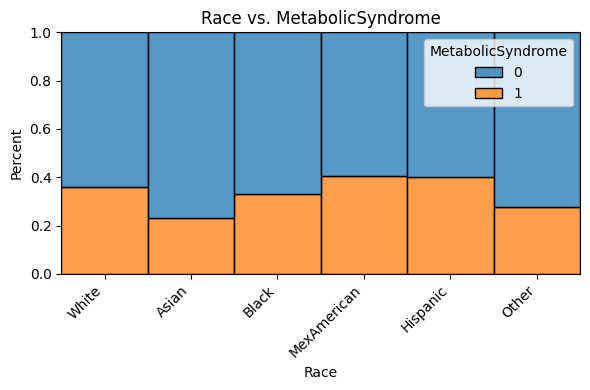

In [62]:
#Multivariate EDA
plot_categorical_vs_target(df, race_feature, target, target_type= 'class');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not really expect race to be a significant indicator of whether or not someone develops metabolic syndrome.
2. Does this feature appear to be a predictor of the target?
  - Even though there is some variation between the classes here, it does not really indicate that this is a predictor of metabolic syndrome.

###Waist Circumference

- WaistCirc: The patient's waist circumference.

In [63]:
#Univariate EDA
#Comfirm data type for function call
waist_feature = 'WaistCirc'
df[waist_feature].dtype

dtype('float64')

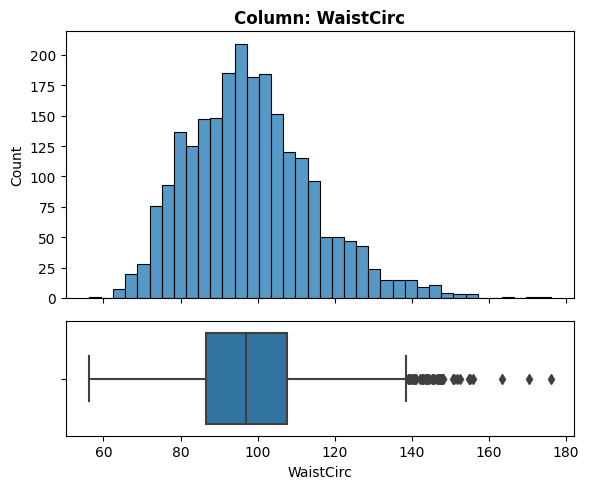

- NaN's Found: 85 (3.54%)
- Unique Values: 635
- Most common value: 'nan' occurs 85 times (3.54%)
- Not constant or quasi-constant.


In [64]:
#Call numeric function
explore_numeric(df, waist_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 85 or 3.54% null values. These will be imputed with the median, due to the presence of outliers in this feature.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 85 NaN's


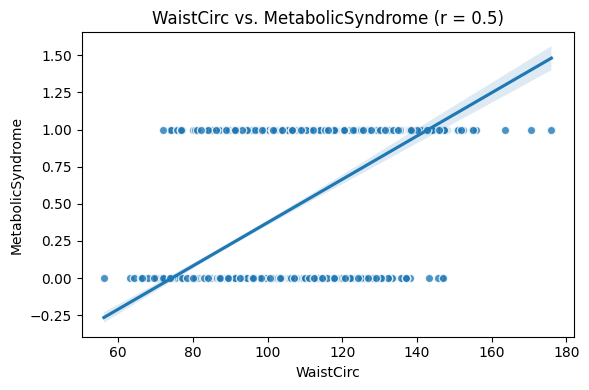

In [65]:
#Multivariate EDA
plot_numeric_vs_target(df, waist_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, knowing that a larger waist circumference can be a predictor for many health conditions, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - Yes, as there is a moderate correlation between the two.

###BMI

- BMI: The patient's BMI (Body Mass Index)

In [66]:
#Univariate EDA
#Comfirm data type for function call
bmi_feature = 'BMI'
df[bmi_feature].dtype

dtype('float64')

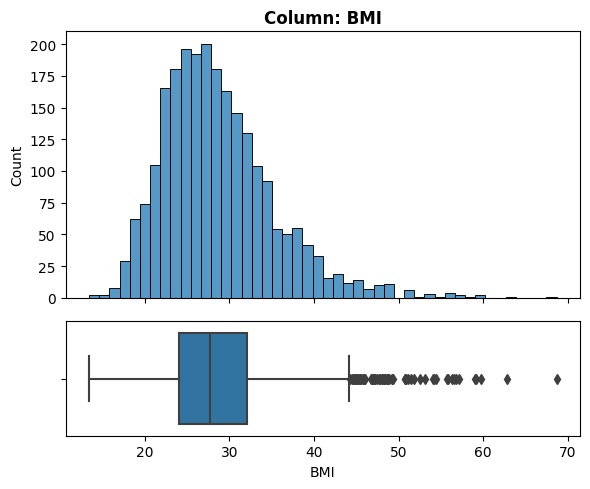

- NaN's Found: 26 (1.08%)
- Unique Values: 322
- Most common value: 'nan' occurs 26 times (1.08%)
- Not constant or quasi-constant.


In [67]:
#Call numeric function
explore_numeric(df, bmi_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 26 or 1.08% null values. These will be imputed with the median, due to the presence of outliers in this feature.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Excluding 26 NaN's


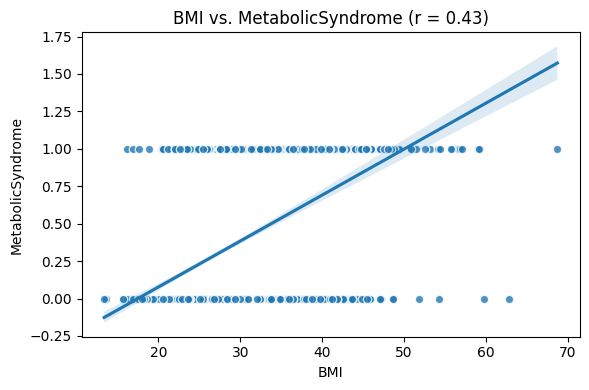

In [68]:
#Multivariate EDA
plot_numeric_vs_target(df, bmi_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, knowing that higher BMI values can be a predictor for many health conditions, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - Yes, as there is a moderate correlation between the two.

###Albuminuria

- Albuminuria: The patient's Albuminuria stage.

In [69]:
#Univariate EDA
#Comfirm data type for function call
albumin_feature = 'Albuminuria'
df[albumin_feature].dtype

dtype('int64')

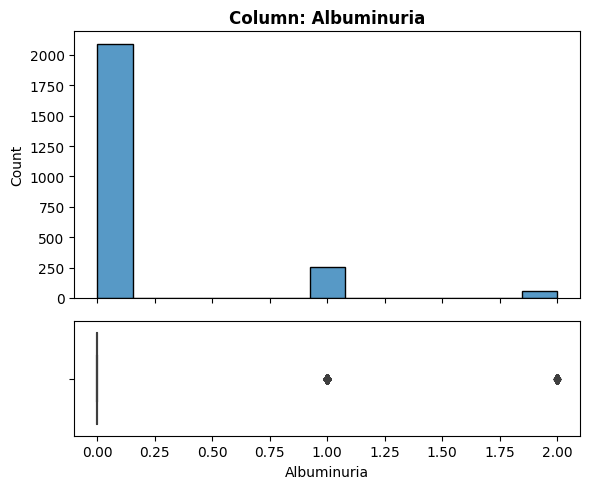

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: '0' occurs 2089 times (87.01%)
- Not constant or quasi-constant.


In [70]:
#Call numeric function
explore_numeric(df, albumin_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

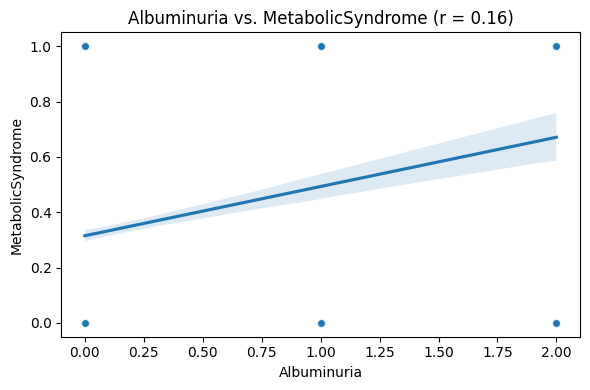

In [71]:
#Multivariate EDA
plot_numeric_vs_target(df, albumin_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this could be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This is not a strong predictor of the target.

###Urine Albumin Creatinine Ratio

- UrAlbCr: The patient's Urine Albumin-Creatinine ratio.

In [72]:
#Univariate EDA
#Comfirm data type for function call
uralbcr_feature = 'UrAlbCr'
df[uralbcr_feature].dtype

dtype('float64')

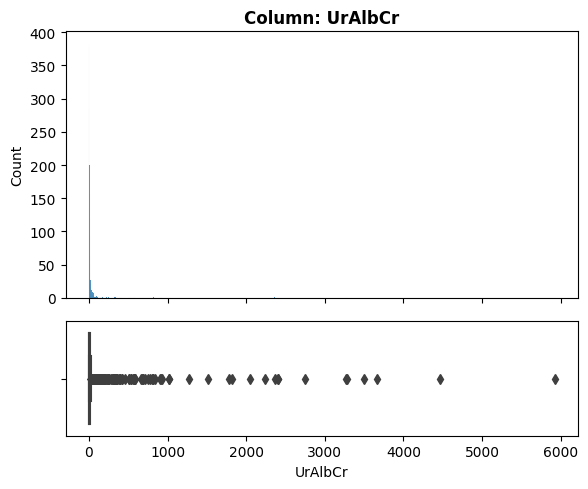

- NaN's Found: 0 (0.0%)
- Unique Values: 1383
- Most common value: '5.0' occurs 18 times (0.75%)
- Not constant or quasi-constant.


In [73]:
#Call numeric function
explore_numeric(df, uralbcr_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- Note: There are a lot of outliers in this feature.

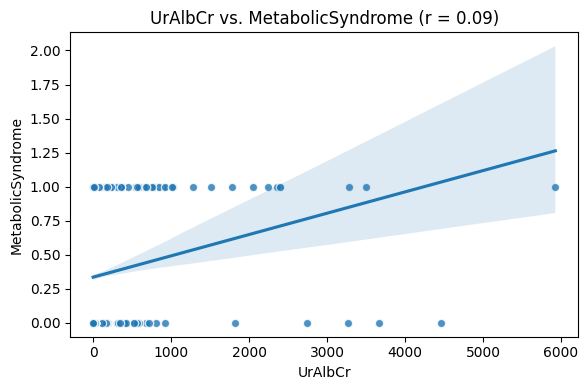

In [74]:
#Multivariate EDA
plot_numeric_vs_target(df, uralbcr_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this could be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This is not a strong predictor of the target.

###Uric Acid

- UricAcid: The patient's uric acid level.

In [75]:
#Univariate EDA
#Comfirm data type for function call
uricacid_feature = 'UricAcid'
df[uricacid_feature].dtype

dtype('float64')

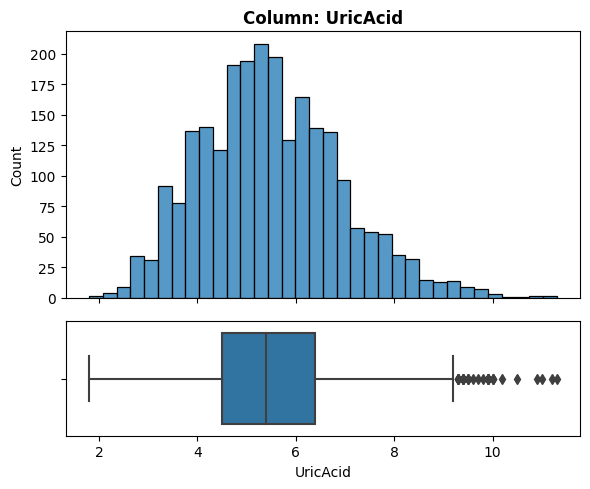

- NaN's Found: 0 (0.0%)
- Unique Values: 88
- Most common value: '5.2' occurs 77 times (3.21%)
- Not constant or quasi-constant.


In [76]:
#Call numeric function
explore_numeric(df, uricacid_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

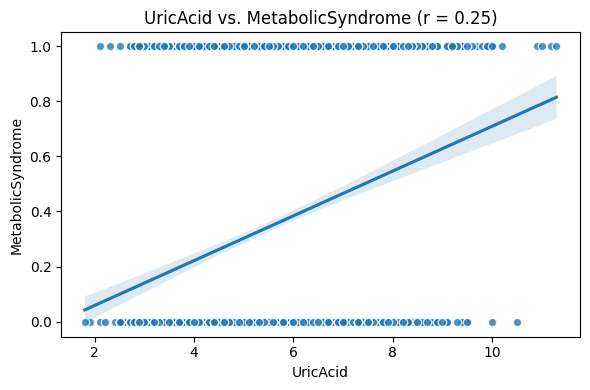

In [77]:
#Multivariate EDA
plot_numeric_vs_target(df, uricacid_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would not expect this feature to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This has a slight correlation, but is not a strong predictor of the target.

###Blood Glucose

- BloodGlucose: The patient's blood glucose level.

In [78]:
#Univariate EDA
#Comfirm data type for function call
glucose_feature = 'BloodGlucose'
df[glucose_feature].dtype

dtype('int64')

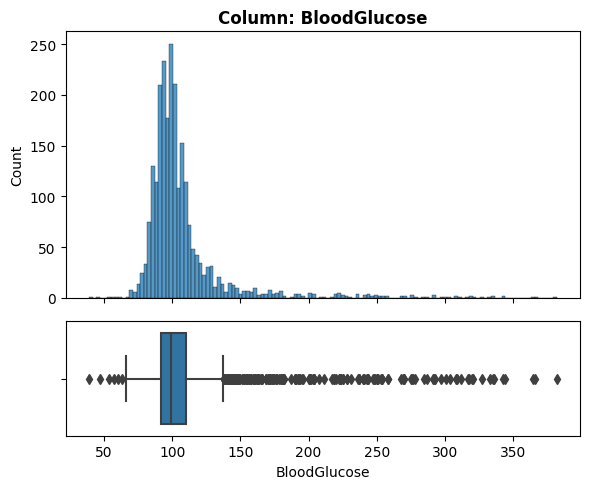

- NaN's Found: 0 (0.0%)
- Unique Values: 187
- Most common value: '97' occurs 90 times (3.75%)
- Not constant or quasi-constant.


In [79]:
#Call numeric function
explore_numeric(df, glucose_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

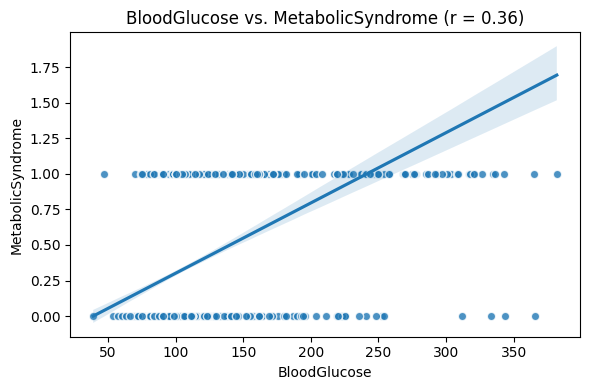

In [80]:
#Multivariate EDA
plot_numeric_vs_target(df, glucose_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - While the correlation is not as strong as I would have thought, this appears to be a slight predictor of the target.

###HDL

- HDL: The patient's HDL (High-Density Lipoprotein) level.

In [81]:
#Univariate EDA
#Comfirm data type for function call
hdl_feature = 'HDL'
df[hdl_feature].dtype

dtype('int64')

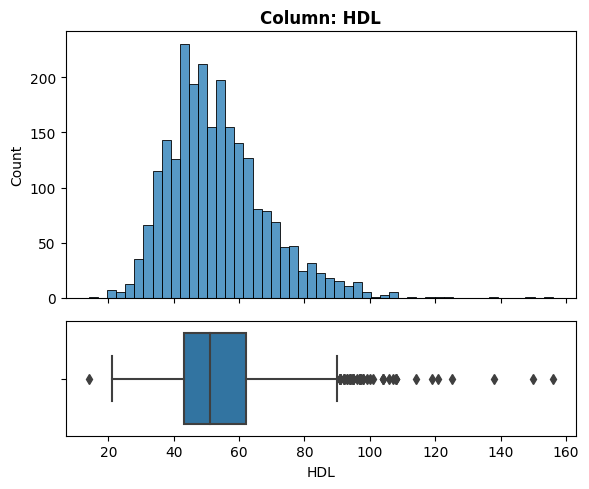

- NaN's Found: 0 (0.0%)
- Unique Values: 93
- Most common value: '48' occurs 87 times (3.62%)
- Not constant or quasi-constant.


In [82]:
#Call numeric function
explore_numeric(df, hdl_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

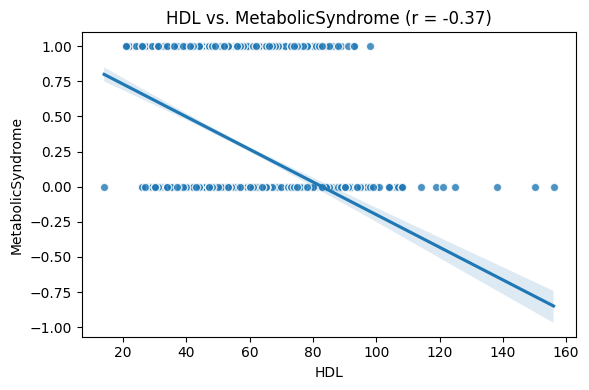

In [83]:
#Multivariate EDA
plot_numeric_vs_target(df, hdl_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - I would expect that this will have an impact on the target, though I'm not sure how strong.
2. Does this feature appear to be a predictor of the target?
  - There is a slight negative correlation here, showing that if your HDL number is higher, you are potentially less likely to have metabolic syndrome.

###Triglycerides

- Triglycerides: The patient's triglycerides level.

In [84]:
#Univariate EDA
#Comfirm data type for function call
triglyceride_feature = 'Triglycerides'
df[triglyceride_feature].dtype

dtype('int64')

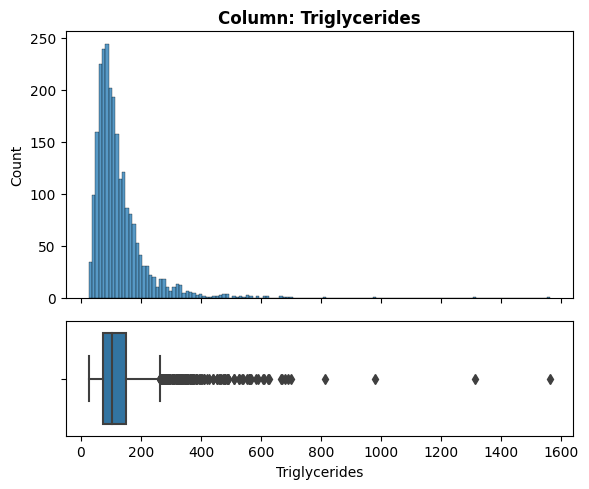

- NaN's Found: 0 (0.0%)
- Unique Values: 345
- Most common value: '75' occurs 34 times (1.42%)
- Not constant or quasi-constant.


In [85]:
#Call numeric function
explore_numeric(df, triglyceride_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

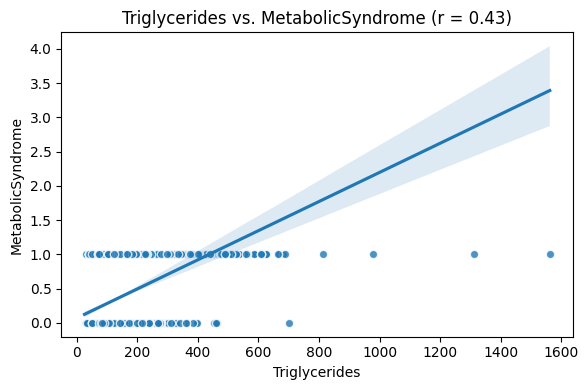

In [86]:
#Multivariate EDA
plot_numeric_vs_target(df, triglyceride_feature, target, target_type= 'reg');

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
   - Yes, I would expect this to be a predictor of the target.
2. Does this feature appear to be a predictor of the target?
  - This has a moderate correlation showing that this is a predictor of the target.

###Metabolic Syndrome

- MetabolicSyndrome: Whether the patient suffers from metabolic syndrome or not.

In [87]:
#Univariate EDA
#Comfirm data type for function call
ms_feature = 'MetabolicSyndrome'
df[ms_feature].dtype

dtype('int64')

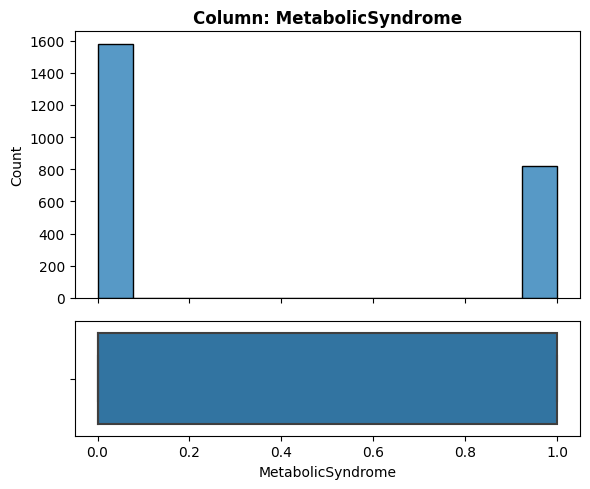

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: '0' occurs 1579 times (65.76%)
- Not constant or quasi-constant.


In [88]:
#Call numeric function
explore_numeric(df, ms_feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
  - This feature is numeric.
2. How many null values? What percentage? What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
  - There are 0 null values.
3. Is the feature constant or quasi-constant?
  - The feature is neither constant nor quasi-constant.
4. What is the cardinality? Is it high (>10)?
  - N/A (numeric)
5. Would we know this feature before the target is determined?
  - Yes.
6. Is there a business case/understanding reason to exclude based on our business case?
  - No.

- No multivariate EDA needed for target feature.